# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

In [2]:
%matplotlib inline


# Classifying Names with a Character-Level RNN

We will biuld and train a character-level *Recurrent Neural
Network* (*RNN*) to classify words.

A character-level RNN reads words as a series of characters -
it outputs a prediction and hidden state at each step, and feeds the
previous hidden state into each next step. We take the final prediction
to be the output, that represents which class the word belongs to.

We want to predict the Language class to which belongs the Surnames.

## Preparing the Data

We will create a dictionary of lists of names per language,
``{language: [names ...]}``.


In [3]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 39), reused 81 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 1.55 MiB | 6.07 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [4]:
# general import

import os
from glob import glob
from io import open
import string
import numpy as np
import random
import torch
import torch.nn as nn

In [5]:
def getFiles(path):
  return glob(path)

file_list = getFiles('./data/Names/*.txt')
print(file_list[:2])

['./data/Names/Russian.txt', './data/Names/Dutch.txt']


In [6]:
!rm -r pytorch-tutorial-nlp-public/

In [7]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

print(readLines(file_list[0]))
print(readLines(file_list[1]))

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin', 'Abakumoff', 'Abakumov', 'Abakumtsev', 'Abakushin', 'Abalakin', 'Abalakoff', 'Abalakov', 'Abaleshev', 'Abalihin', 'Abalikhin', 'Abalkin', 'Abalmasoff', 'Abalmasov', 'Abaloff', 'Abalov', 'Abamelek', 'Abanin', 'Abankin', 'Abarinoff', 'Abarinov', 'Abasheev', 'Abashev', 'Abashidze', 'Abashin', 'Abashkin', 'Abasov', 'Abatsiev', 'Abaturoff', 'Abaturov', 'Abaza', 'Abaziev', 'Abbakumov', 'Abbakumovsky', 'Abbasov', 'Abdank-Kossovsky', 'Abdeev', 'Abdildin', 'Abdrahimoff', 'Abdrahimov', 'Abdrahmanoff', 'Abdrahmanov', 'Abdrakhimoff', 'Abdrakhimov', 'Abdrakhmanoff', 'Abdrakhmanov', 'Abdrashitoff', 'Abdrashitov', 'Abdrazakoff', 'Abdrazakov', 'Abdulaev', 'Abdulatipoff', 'Abdulatipov', 'Abdulazizoff', 'Abdulazizov', 'Abdulbasiroff', 'Abdulbasirov', 'Abdulbekoff', 'Abdulbekov', 'Abdulgapuroff', 'Abdulgapurov', 'Abdulgaziev', 'Abdulhabiroff', 'Abdulhabirov', 'Abdulin', 'Abdulkadyroff', 

In [8]:
# category_words is a dict with the key as the language
# and the value a list with all the possible names in the specific language
category_words = {}
all_categories = []
alphabet = set()

for filename in file_list:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for word in lines:
      alphabet |= set(word)
    category_words[category] = lines

# letter to index
l_to_i = dict(zip(alphabet, range(len(alphabet))))
print(category_words)
n_categories = len(all_categories)
print(f'N. of languages: {n_categories}')
print(l_to_i)
n_letters = len(l_to_i)
print(f'The alphabet has {n_letters} letters')

{'Russian': ['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin', 'Abakumoff', 'Abakumov', 'Abakumtsev', 'Abakushin', 'Abalakin', 'Abalakoff', 'Abalakov', 'Abaleshev', 'Abalihin', 'Abalikhin', 'Abalkin', 'Abalmasoff', 'Abalmasov', 'Abaloff', 'Abalov', 'Abamelek', 'Abanin', 'Abankin', 'Abarinoff', 'Abarinov', 'Abasheev', 'Abashev', 'Abashidze', 'Abashin', 'Abashkin', 'Abasov', 'Abatsiev', 'Abaturoff', 'Abaturov', 'Abaza', 'Abaziev', 'Abbakumov', 'Abbakumovsky', 'Abbasov', 'Abdank-Kossovsky', 'Abdeev', 'Abdildin', 'Abdrahimoff', 'Abdrahimov', 'Abdrahmanoff', 'Abdrahmanov', 'Abdrakhimoff', 'Abdrakhimov', 'Abdrakhmanoff', 'Abdrakhmanov', 'Abdrashitoff', 'Abdrashitov', 'Abdrazakoff', 'Abdrazakov', 'Abdulaev', 'Abdulatipoff', 'Abdulatipov', 'Abdulazizoff', 'Abdulazizov', 'Abdulbasiroff', 'Abdulbasirov', 'Abdulbekoff', 'Abdulbekov', 'Abdulgapuroff', 'Abdulgapurov', 'Abdulgaziev', 'Abdulhabiroff', 'Abdulhabirov', 'Abdulin', 'Abdu

In [9]:
# this is all the necessary code to set the seed
def set_seed(seed : int = 123):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [10]:
set_seed()

### Turning Names into Tensors

As always, we have to convert textual data into tensors.

To represent a single letter, we use a "one-hot vector" of size
``(1 x n_letters)``, where 1 is the respective index of the letter it is representing.

To make a word we combine a bunch of those representations into a 2D matrix
``(word_length x 1 x n_letters)``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here, for the sake of simplicity.




# Question 1
Create the auxiliary function to process the data to have the input suitable for `nn.Embedding`. This is because one of the following questions will be to try not to use one-hot-encoding representation, but use the embedding layer instead.

In [11]:
def letterToIndex(letter):
  '''
  Returns the index of a letter in the alphabet
  '''
  return l_to_i[letter]

def wordToOneHotTensor(word):
  '''
  Returns the word in zero-hot encoding
  '''
  tensor = torch.zeros(len(word), 1, n_letters).long()
  for idx, let in enumerate(word):
      tensor[idx][0][letterToIndex(let)] = 1
  return tensor

def wordToEmbedding(word):
  indexes = [letterToIndex(letter) for letter in word]
  return torch.tensor(indexes, dtype=torch.long)

tmp = 'Aarle'

print(f'N. of letters {len(alphabet)}')
print(f'Length of the word {len(tmp)}\n')
print(wordToOneHotTensor(tmp).size())
print(wordToOneHotTensor(tmp))
print('\n')
print(wordToEmbedding(tmp).size())
print(wordToEmbedding(tmp))

N. of letters 87
Length of the word 5

torch.Size([5, 1, 87])
tensor([[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0

# Question 2
Implement the Vanilla RNN considering a batch size of dimension 1 (the simplest case).

## Creating the Network

Here, we are going to create RNNs with one only layer for the sake of simplicity. However, these models can be easily expanded to the more general case of having more layers.  

The Vanilla RNN is just 2 linear layers which operate on an input and hidden state.




In [12]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [13]:
class RNNEmb(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNNEmb, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.embedding = nn.Embedding(input_size, hidden_size)

    self.e2h = nn.Linear(hidden_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    embedded = self.embedding(input)
    combined = torch.cat((torch.unsqueeze(embedded, 0), hidden), 1)
    hidden = self.e2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

# Question 3
Implement an LSTM cell considering a batch size of dimension 1 (the simplest case).

In [14]:
class LSTM(torch.nn.Module):

    def __init__(self, input_length, hidden_length, output_length, type_layer):
        super(LSTM, self).__init__()

        self.input_length = input_length
        self.hidden_length = hidden_length
        self.output_length = output_length
        self.type_layer = type_layer

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_input_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.linear_input_w2 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_input = nn.Sigmoid()
        self.tanh_input = nn.Tanh()

        # out gate components
        self.linear_output_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_out = nn.Sigmoid()

        self.linear_output_final = nn.Linear(self.hidden_length, self.output_length, bias=True)
        self.activation_final = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forget(self, x, h):
        #print('forget',torch.cat((x, h), dim=1).shape)
        ret = self.linear_forget_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_forget(ret)


    def input_gate(self, x, h):
        # input gate
        i_t = self.linear_input_w1(torch.cat((x, h), dim=1))
        C_t = self.linear_input_w2(torch.cat((x, h), dim=1))
        return self.sigmoid_input(i_t), self.tanh_input(C_t)


    def out_gate(self, x, h):
        ret = self.linear_output_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_out(ret)


    def forward(self, x, tuple_in):
        x = x.to(torch.float32)
        (h, c_prev) = tuple_in

        # forge gate
        f_t = self.forget(x, h)

        # input gate
        i_t, c_t = self.input_gate(x, h)

        # updating the cell memory
        c_next = (c_prev * f_t) + (i_t * c_t)
        #self.c_next = c_next

        # calculate the main output gate
        o = self.out_gate(x, h)

        # produce next hidden output
        #print('output', (o * self.activation_final(c_next)).shape)
        h_next = o * self.activation_final(c_next)

        return self.log_softmax(self.linear_output_final(h_next)), (h_next, c_next)


    def initHidden(self):
        return (torch.zeros(1, self.hidden_length).to(torch.float32), torch.zeros(1, self.hidden_length).to(torch.float32))

## Training
Preparing for Training
----------------------

The output of the network is a likelihood of each category. Use ``Tensor.topk`` to get the index
of the greatest value:




In [15]:
def categoryFromOutput(output):
    top_val, top_idx = output.topk(1)
    # print(top_val)
    # print(top_idx)
    category_idx = top_idx[0].item()
    return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its
language):




In [16]:
print(all_categories)

['Russian', 'Dutch', 'Japanese', 'Arabic', 'Chinese', 'Vietnamese', 'Italian', 'Korean', 'Polish', 'Czech', 'German', 'Greek', 'Irish', 'Spanish', 'English', 'French', 'Portuguese', 'Scottish']


# Related to Question 1
In order to use the embeddings in place of one-hot-encoded representation, you should modify also the function `randomChoice()` in the following snippet of code to have the correct input data.

In [17]:
import random

def randomChoice(l):
  '''
  Returns a random integer given the list of languages
  '''
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(model):
    category = randomChoice(all_categories)
    word = randomChoice(category_words[category])
    # create a long tensor with the index of the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    if model == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)

    return category, word, category_tensor, word_tensor

for ty in ['embeds', 'linear']:
  for i in range(4):
    category, word, category_tensor, word_tensor = randomTrainingExample(ty)
    print('category =', category, '\n word =', word, '\n category_tensor =', category_tensor, '\n word_tensor =', word_tensor, '\n len word_tensor =', word_tensor.size())
    print('\n')

category = Dutch 
 word = Meeuweszen 
 category_tensor = tensor([1]) 
 word_tensor = tensor([44, 77, 77, 45, 12, 77, 59, 24, 77,  6]) 
 len word_tensor = torch.Size([10])


category = Japanese 
 word = Sugitani 
 category_tensor = tensor([2]) 
 word_tensor = tensor([33, 45, 55, 86, 46, 25,  6, 86]) 
 len word_tensor = torch.Size([8])


category = Spanish 
 word = Ibarra 
 category_tensor = tensor([13]) 
 word_tensor = tensor([53, 84, 25, 83, 83, 25]) 
 len word_tensor = torch.Size([6])


category = Arabic 
 word = Assaf 
 category_tensor = tensor([3]) 
 word_tensor = tensor([ 7, 59, 59, 25, 85]) 
 len word_tensor = torch.Size([5])


category = Dutch 
 word = Reijnder 
 category_tensor = tensor([1]) 
 word_tensor = tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Training the Network
 In the following change the initialisation with the model you want to use.




In [18]:
n_hidden = 128
criterion = nn.NLLLoss()

In [19]:
rnn = RNN(n_letters, n_hidden, n_categories, 'linear')

In [20]:
rnn_embeds = RNNEmb(n_letters, n_hidden, n_categories, 'embeds')

In [21]:
lstm = LSTM(n_letters, n_hidden, n_categories, 'linear')

Each loop of training will:

1. Create input and target tensors
2. Read each letter in and keep the hidden state for next letter
3. Compare final output to target
4. Back-propagate
5. Return the output and loss




# Question 3
After having tryied the learning rate which is proposed in the script, `0.005`, use the learning rate equal to `1`. What is happening? Can you explaing why?

VANISHING EXPLODING PROBLEM

What is the quickest way to get rid of the problem? Modify the code trying to implement a possible solution.

GRADEINT CLIPPING

What is the other problem this kind of network has? And what are the possible solutions?

Limited Contextual Information & Difficulty Learning Long-Term Dependencies

In [22]:
from torch import optim


def train(category_tensor, word_tensor, model, optimizer):
    # If you set this too high, it might explode. If too low, it might not learn
    #learning_rate = 0.005
    #optimizer = optim.SGD(model.parameters(), lr = lr)
    #optimizer = optim.Adam(model.parameters(), lr = learning_rate)


    #h_lstm, h_rnn = None, None
    #h = None

    #if model.__class__.__name__ == "LSTM": h_lstm = model.initHidden()
    #else: h_rnn = model.initHidden()
    h = model.initHidden()

    optimizer.zero_grad()
    # iterate over the word for all the letters in the word
    for i in range(word_tensor.size(0)):
      # modify the following with the correct implementation depending on the
      # network you are using


        #output, h_lstm = model(word_tensor[i], h_lstm)
      #else:
        #output, h_rnn = model(word_tensor[i], h_rnn)
      #print(model.__class__.__name__, word_tensor[i])
      output, h = model(word_tensor[i], h)
      #if model.__class__.__name__ == "LSTM": output = model.log_softmax(output)

    #print(output.size(), category_tensor.size())
    loss = criterion(output, category_tensor)
    loss.backward()

    # Gradient clipping using that clips the gradients using a vector norm
    # Clips gradient norm of an iterable of parameters.
    #The norm is computed over all gradients together, as if they were concatenated into a single vector. Gradients are modified in-place.
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)

    # Basic Gradient Clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 1.)

    optimizer.step()
    return output, loss.item()

The ``train`` function returns the output and loss we can print what are its predictions and also to keep track of the loss.
We can choose how many examples print these outputs thanks to ``print_every``.




In [23]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

def run_training(model, optimizer):
  n_iters = 100000
  print_every = 5000
  plot_every = 1000

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []



  start = time.time()

  for iter in range(1, n_iters + 1):
      category, word, category_tensor, word_tensor = randomTrainingExample(model.type_layer)
      #print(type(category), type(word), category_tensor[0].dtype, word_tensor[0].dtype)

      output, loss = train(category_tensor, word_tensor, model, optimizer)
      current_loss += loss

      if iter % print_every == 0:
          category_pred, category_idx = categoryFromOutput(output)
          correct = 'OK' if category_pred == category else 'NO (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, word, category_pred, correct))

      # add the current loss to the list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

  return all_losses

In [24]:
lr = 0.005
optimizer_rnn = optim.SGD(rnn.parameters(), lr = lr)
#optimizer_rnn = optim.Adam(rnn.parameters(), lr = lr)

rnn_losses = run_training(rnn, optimizer_rnn)

5000 5% (0m 9s) 2.8279 Praseta / Spanish NO (Czech)
10000 10% (0m 18s) 1.4524 Rhee / Korean OK
15000 15% (0m 28s) 4.7612 Donk / Korean NO (Dutch)
20000 20% (0m 36s) 1.8029 John / Korean NO (Irish)
25000 25% (0m 46s) 0.1674 Cipriani / Italian OK
30000 30% (0m 57s) 1.1987 Ahn / Korean OK
35000 35% (1m 5s) 1.2278 Loritz / German OK
40000 40% (1m 15s) 1.0627 Chu / Korean NO (Vietnamese)
45000 45% (1m 24s) 2.0304 Chung / Chinese NO (Vietnamese)
50000 50% (1m 33s) 0.6225 Zhang / Chinese OK
55000 55% (1m 43s) 3.3870 Close / Scottish NO (Greek)
60000 60% (1m 52s) 2.4234 Scott / English NO (Scottish)
65000 65% (2m 1s) 0.4277 Mui / Chinese OK
70000 70% (2m 10s) 0.3170 Teng / Chinese OK
75000 75% (2m 20s) 0.2962 Kasprzak / Polish OK
80000 80% (2m 29s) 0.5516 Valdez / Spanish OK
85000 85% (2m 38s) 0.9084 Kranz / German OK
90000 90% (2m 47s) 0.4270 Yoshida / Japanese OK
95000 95% (2m 57s) 3.8733 Kan / Chinese NO (Dutch)
100000 100% (3m 7s) 0.6006 Essert / German OK


In [25]:
lr = 0.005
optimizer_rnn_embeds = optim.SGD(rnn_embeds.parameters(), lr = lr)
#optimizer_rnn_embeds = optim.Adam(rnn_embeds.parameters(), lr = lr)

rnn_embeds_losses = run_training(rnn_embeds, optimizer_rnn_embeds)

5000 5% (0m 10s) 1.7162 Paulissen / English NO (Dutch)
10000 10% (0m 21s) 0.9339 Markwardt / German OK
15000 15% (0m 32s) 0.6500 Sayegh / Arabic OK
20000 20% (0m 44s) 1.8529 Achteren / German NO (Dutch)
25000 25% (0m 55s) 0.7813 Tsaplinsky / Russian OK
30000 30% (1m 5s) 0.9643 An / Vietnamese OK
35000 35% (1m 16s) 0.6471 Sun / Chinese OK
40000 40% (1m 30s) 1.0863 Noguchi / Japanese OK
45000 45% (1m 42s) 1.8004 Yao / Korean NO (Chinese)
50000 50% (1m 52s) 0.5655 Schultz / German OK
55000 55% (2m 15s) 0.2150 Suzuki / Japanese OK
60000 60% (2m 32s) 0.4557 Truong / Vietnamese OK
65000 65% (2m 44s) 0.2633 Kijek / Polish OK
70000 70% (2m 56s) 1.3552 Jez / Chinese NO (Polish)
75000 75% (3m 9s) 4.1357 Colling / Scottish NO (Czech)
80000 80% (3m 19s) 1.0511 Bouchard / French OK
85000 85% (3m 32s) 0.2031 Perreault / French OK
90000 90% (3m 47s) 0.0574 Huynh / Vietnamese OK
95000 95% (3m 58s) 1.1006 Beauchene / French OK
100000 100% (4m 9s) 3.8053 Phocas / Czech NO (Greek)


In [26]:
lr = 0.005
#optimizer_lstm = optim.SGD(lstm.parameters(), lr = lr)
optimizer_lstm = optim.Adam(lstm.parameters(), lr = lr)

lstm_losses = run_training(lstm, optimizer_lstm)

5000 5% (0m 35s) 2.7761 Freud / French NO (German)
10000 10% (1m 26s) 2.0002 Luo / Vietnamese NO (Chinese)
15000 15% (2m 8s) 0.8808 Kruessel / Czech OK
20000 20% (2m 43s) 0.8761 Doyle / Irish OK
25000 25% (3m 22s) 0.0990 Nam / Korean OK
30000 30% (3m 56s) 0.3510 Segher / Dutch OK
35000 35% (4m 30s) 5.1310 To The First Page / French NO (Russian)
40000 40% (5m 8s) 0.0121 Takei / Japanese OK
45000 45% (5m 43s) 0.0297 Suk / Korean OK
50000 50% (6m 21s) 0.0557 Schoonraad / Dutch OK
55000 55% (7m 7s) 1.6810 Chu / Vietnamese NO (Korean)
60000 60% (7m 56s) 2.7445 Eberg / German NO (Russian)
65000 65% (8m 37s) 2.4480 Chu / Vietnamese NO (Korean)
70000 70% (9m 14s) 0.0265 Arvanitoyannis / Greek OK
75000 75% (9m 49s) 0.0015 Airaldi / Italian OK
80000 80% (10m 26s) 1.9161 Greer / French NO (English)
85000 85% (11m 2s) 0.0006 Gomulka / Polish OK
90000 90% (11m 50s) 0.0477 Langlais / French OK
95000 95% (12m 46s) 0.0164 Ślusarski / Polish OK
100000 100% (13m 20s) 0.2108 Peisar / Czech OK


# Question 4
Use the LSTM to make the predictions, feel free to modify the optimizer and/or the learning rate to see the training loss decreasing. Pay attention that the LSTM returns a number of components different by the ones that are returned by a Vanilla RNN, thus modify the code accordingly (especially the `train()` function).


# Question 5
Modify the network of the Vanilla RNN to use an embedding layer and not using the one-hot-encoding representation and train again the network. Verify that the network has been trained considering the training loss. It has to be decreasing.

### See that the training loss is decreasing

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def print_losses(all_losses, title):
  plt.figure()
  plt.plot(all_losses)
  plt.xlabel('Iterations')
  plt.ylabel('NLLLoss')
  plt.title(title)
  plt.show()

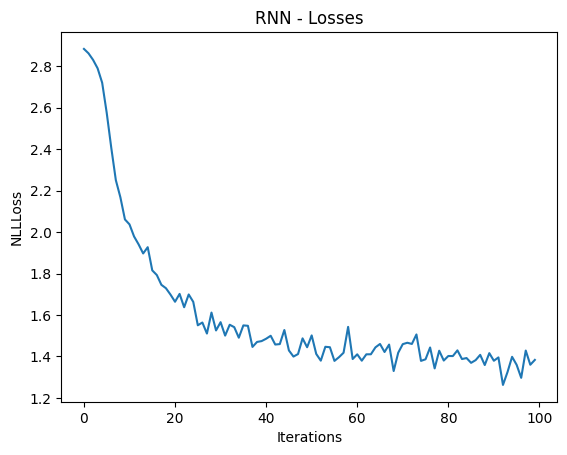

In [28]:
print_losses(rnn_losses, 'RNN - Losses')

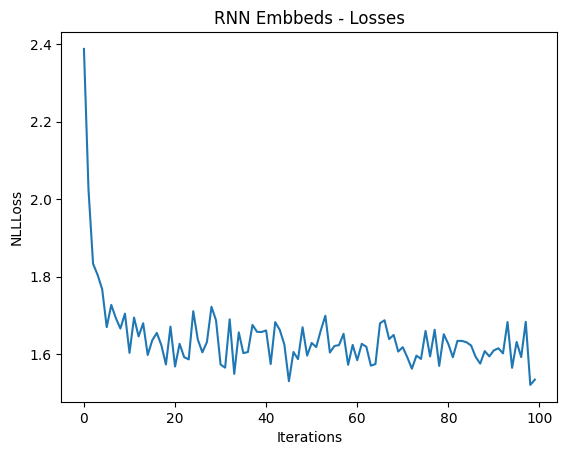

In [29]:
print_losses(rnn_embeds_losses, 'RNN Embbeds - Losses')

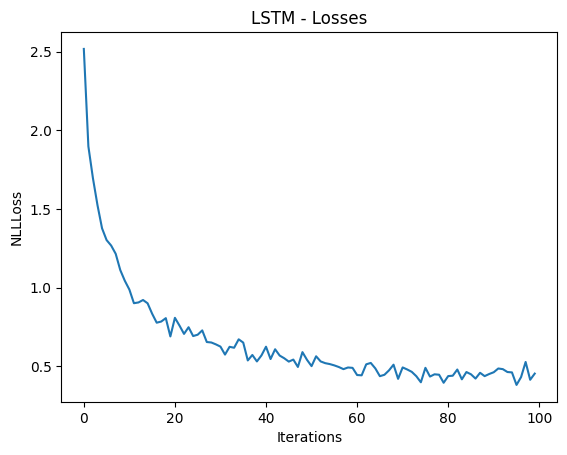

In [30]:
print_losses(lstm_losses, 'LSTM - Losses')

In [31]:
# Just return an output given a line
def evaluate(line_tensor, model):
    hidden = model.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def create_confusion_matrix(model):
  # Keep track of correct guesses in a confusion matrix
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, line, category_tensor, line_tensor = randomTrainingExample(model.type_layer)
      output = evaluate(line_tensor, model)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig, ax = plt.subplots(figsize=(20, 20))
  cax = ax.matshow(confusion)

  # Display values inside the cells
  for i in range(len(all_categories)):
      for j in range(len(all_categories)):
          ax.text(j, i, str(round(confusion[i, j].item(), 3)), va='center', ha='center', color='white')

  fig.colorbar(cax, shrink=0.8)

  # Set up axes
  ax.set_xticklabels([''] + all_categories, rotation=45)
  ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.xaxis.set_label_coords(0.5, -0.1)
  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.set_ticks_position("none")

  plt.title(f'Confusion Matrix of {model.__class__.__name__}')
  plt.show()

<ipython-input-31-323fde681378>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-31-323fde681378>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


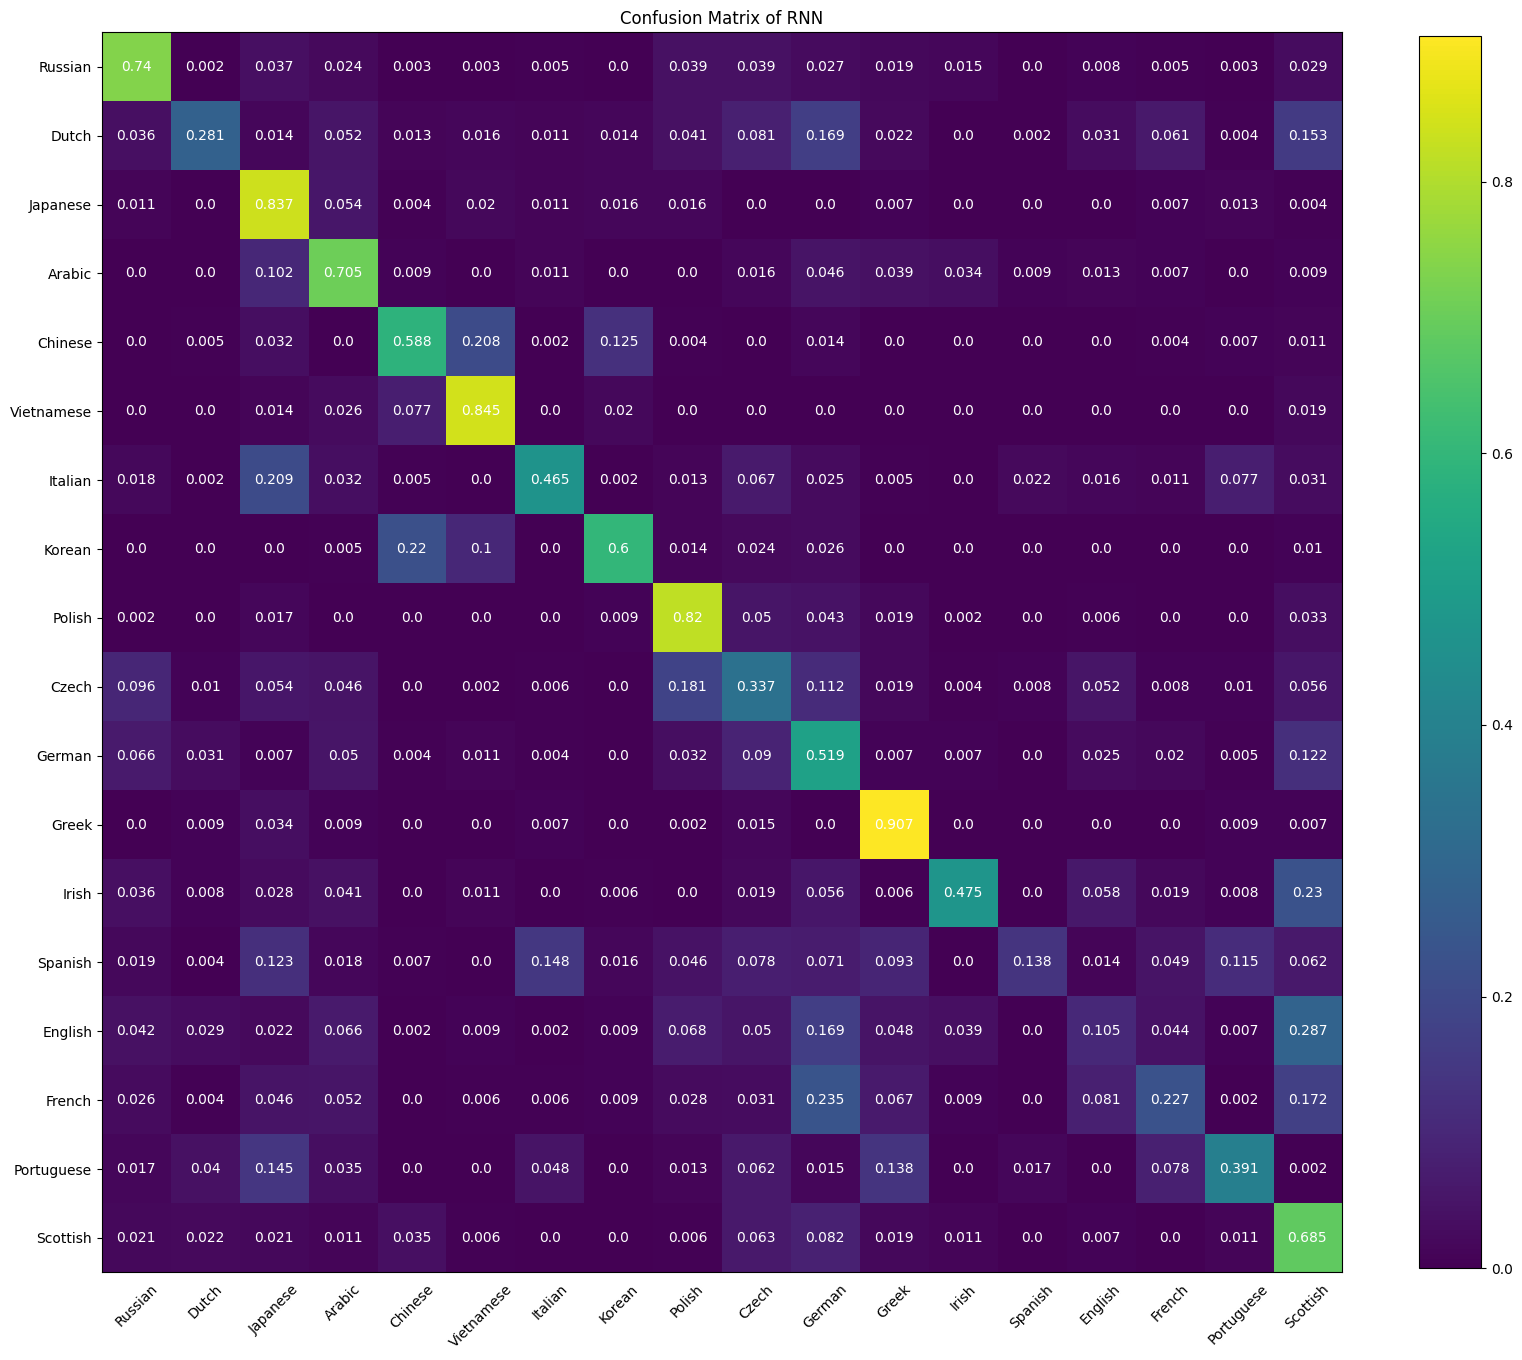

In [32]:
create_confusion_matrix(rnn)

<ipython-input-31-323fde681378>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-31-323fde681378>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


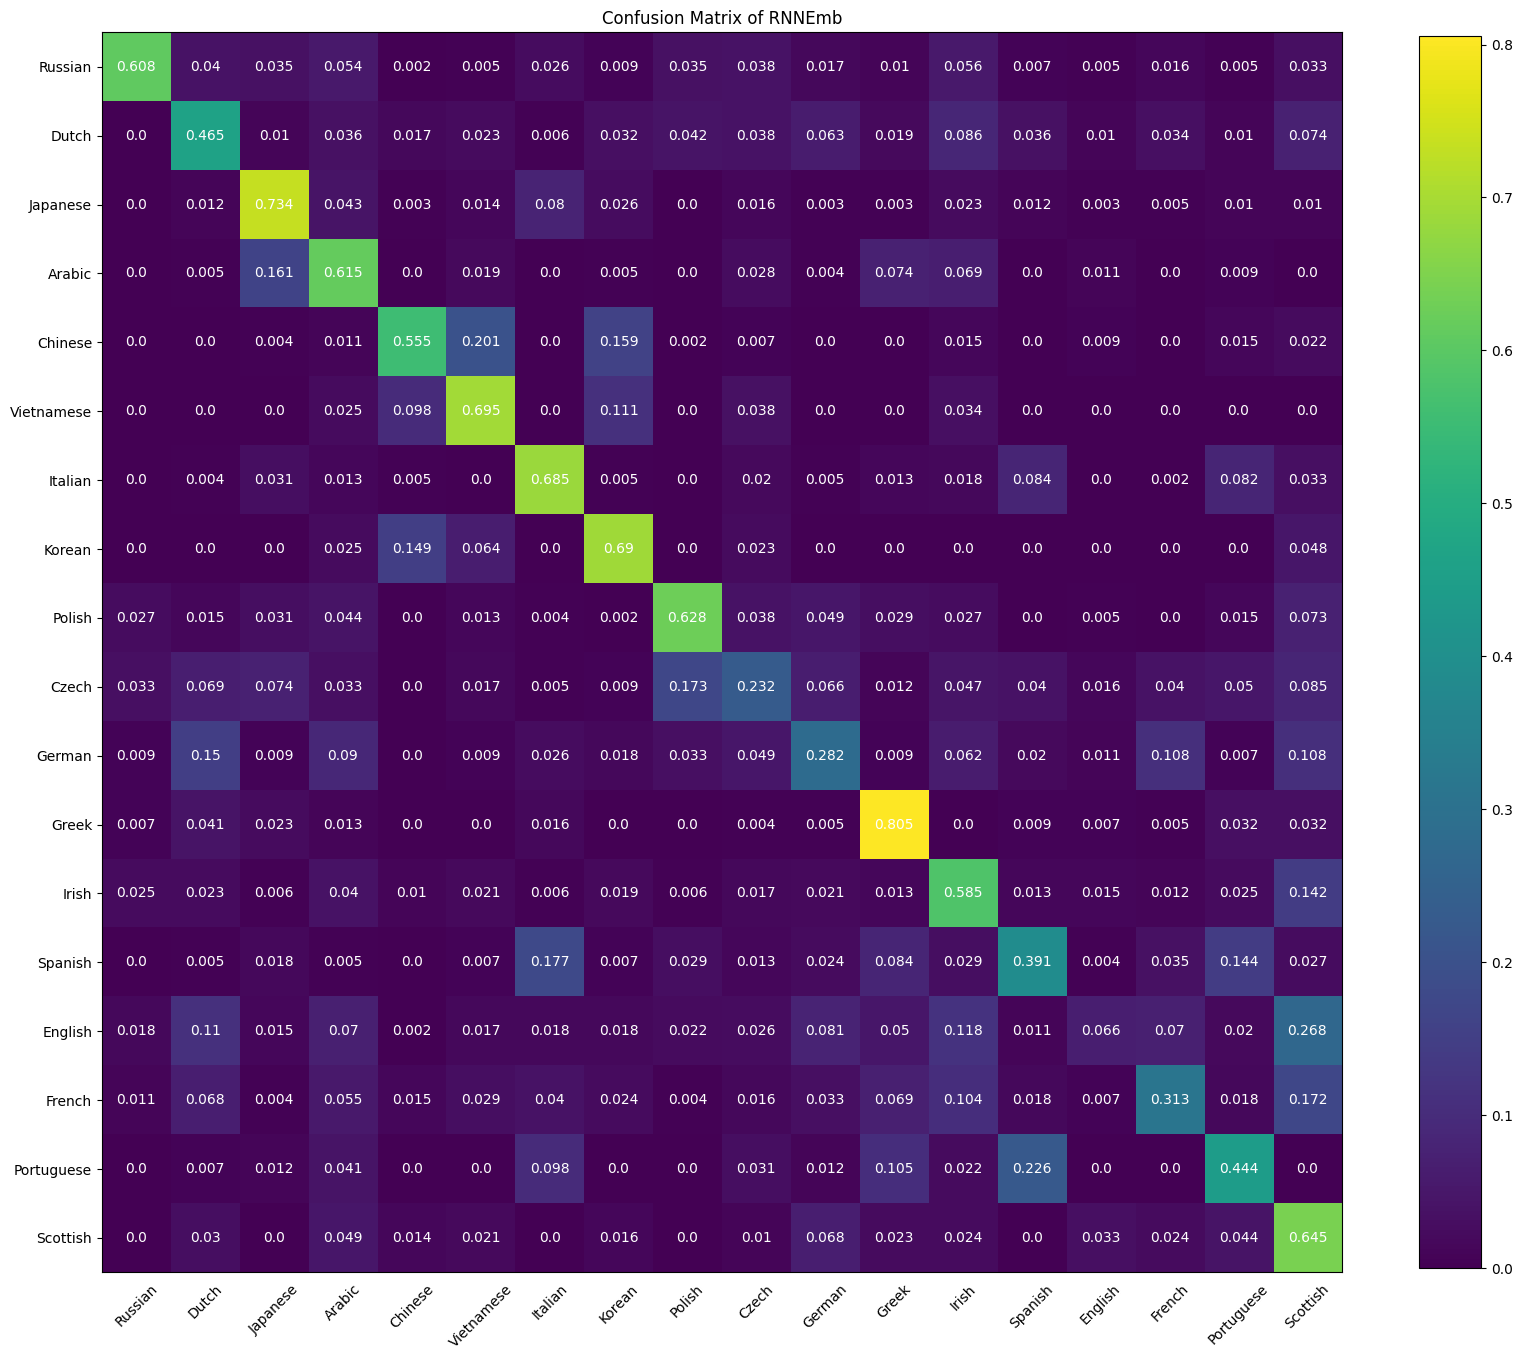

In [33]:
create_confusion_matrix(rnn_embeds)

<ipython-input-31-323fde681378>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-31-323fde681378>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


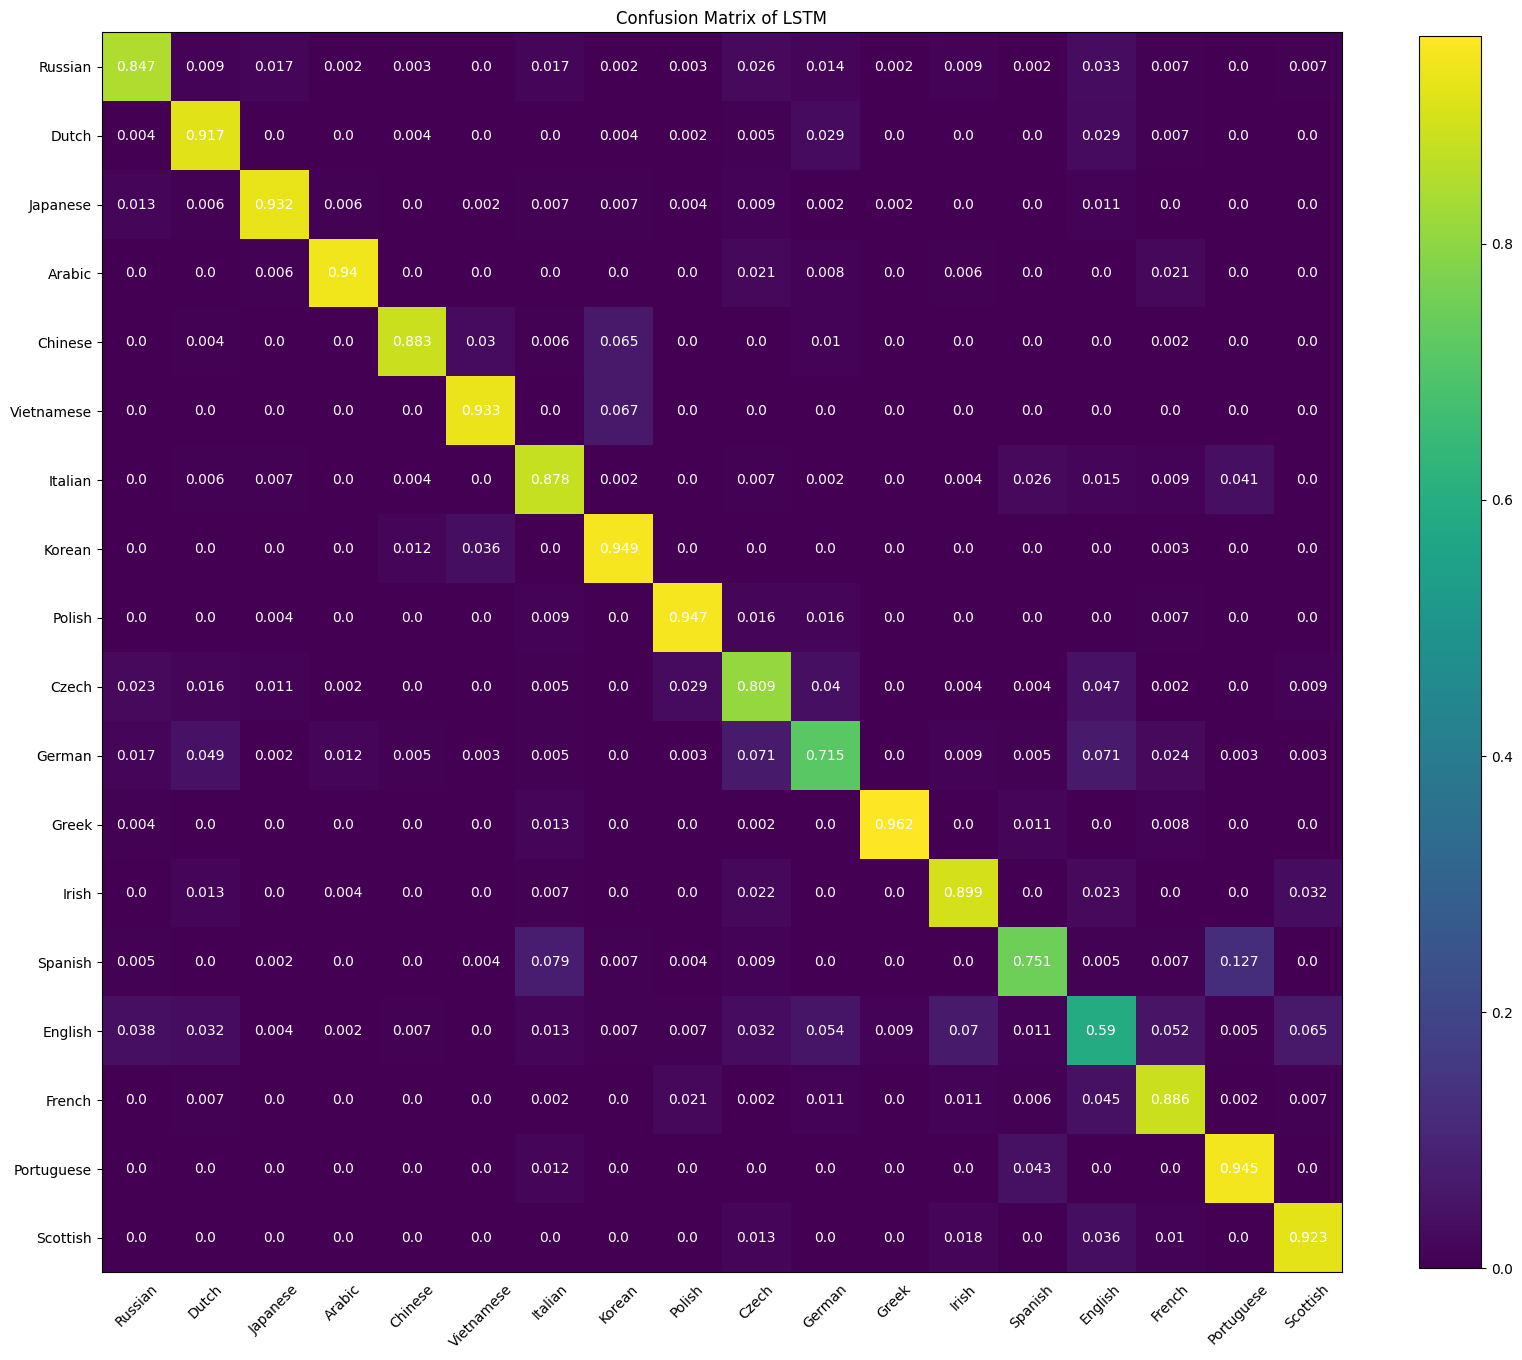

In [34]:
create_confusion_matrix(lstm)

# Question 6
Make a function to extract the embedding and visualise in the 2D space with the color w.r.t. the Language class. Feel free to modify the `get_embeddings()` function to return what you think could be useful for the plotting. Let's use also the cosine similarity between the embeddings to see if the embedding has a sense.

In [35]:
def getTrainingSample(word, model):
    # create a long tensor with the index of the language
    if model.type_layer == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)
    return word_tensor

In [63]:
name_to_lang = {}#, name_to_idx, idx_to_name = {}, {}, {}
#idx = 0
for lang, list_names in category_words.items():
  for name in list_names:
    name_to_lang[name] = lang
    #name_to_idx[name] = idx
    #idx_to_name[idx] = name
    #idx += 1

names, languages_names = list(name_to_lang.keys()), list(name_to_lang.values())

In [68]:
def get_embedding(model):

  hiddens = np.empty((0, 256)) if model.__class__.__name__ == 'LSTM' else np.empty((0,128))

  model.eval()  # Set the model in evaluation mode

  # Extract hidden states from your dataset
  # Assuming you have a dataset of sequences, you can iterate over them and collect the hidden states

  # Iterate over your dataset and extract hidden states
  for name, _ in name_to_lang.items():
      hidden = model.initHidden()

      tensor_name = getTrainingSample(name, model)

      for i in range(tensor_name.size(0)):

          with torch.no_grad():
            _, hidden = model(tensor_name[i], hidden)

      hiddens =  np.vstack((hiddens, torch.cat(hidden, dim = 1))) if model.__class__.__name__ == 'LSTM' else np.vstack((hiddens, hidden))

  return hiddens

In [73]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity


def print_and_get_embeddings(model, indices, title):
    hiddens = get_embedding(model)

    colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'blue', 'gray', 'orange', 'purple', 'brown', 'pink', 'teal', 'olive', 'indigo', 'violet', 'gold']

    tsne = TSNE()
    embed_tsne = tsne.fit_transform(hiddens.squeeze()[indices,:])
    embed_tsne_all = tsne.fit_transform(hiddens.squeeze())


    key_index = list(category_words.keys())

    fig, ax = plt.subplots(figsize=(12, 12))

    # Create an empty list to store unique legend entries
    legend_entries = []

    for i, val in enumerate(indices):
        color = colors[key_index.index(languages_names[val])]

        # Check if the language is already in the legend_entries list
        if languages_names[val] not in legend_entries:
            # Add the language to legend_entries to avoid duplicates
            legend_entries.append(languages_names[val])
            plt.scatter(*embed_tsne[i, :], color=color, label=languages_names[val])
        else:
            # If the language is already in legend_entries, don't add a label
            plt.scatter(*embed_tsne[i, :], color=color)

        # plt.annotate(words[val]+' ('+languages[val]+')', (embed_tsne[i, 0], embed_tsne[i, 1]), alpha=0.7)

    plt.title(title)

    # Display the legend with unique entries
    plt.legend()
    plt.show()

    return hiddens, embed_tsne_all

In [74]:
def get_embds_sim(embeddings):
  sim = cosine_similarity(embeddings)
  np.fill_diagonal(sim, -1.0)
  return sim

In [75]:
viz_words = 2000
indices = np.random.choice(len(name_to_lang), viz_words)

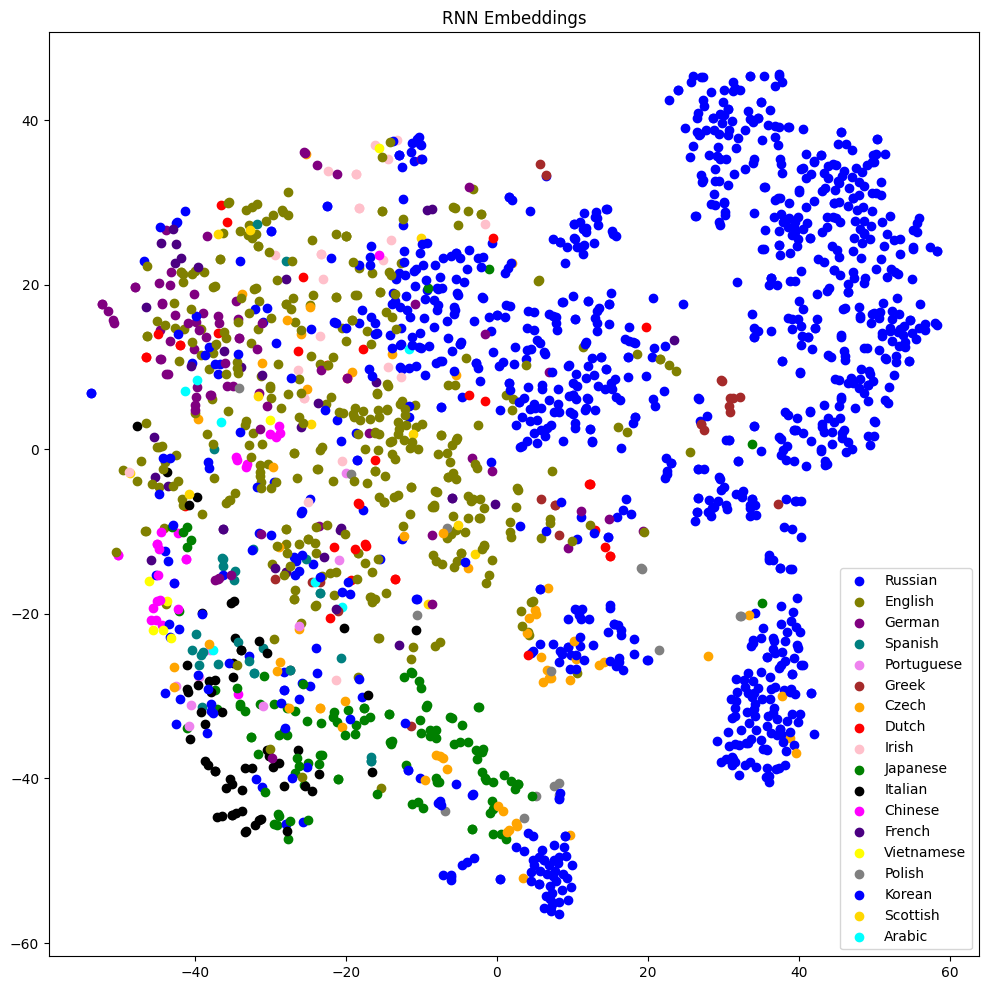

In [76]:
hidden_rnn, tsne_rnn = print_and_get_embeddings(rnn, indices, 'RNN Embeddings')
sim_rnn = get_embds_sim(hidden_rnn)

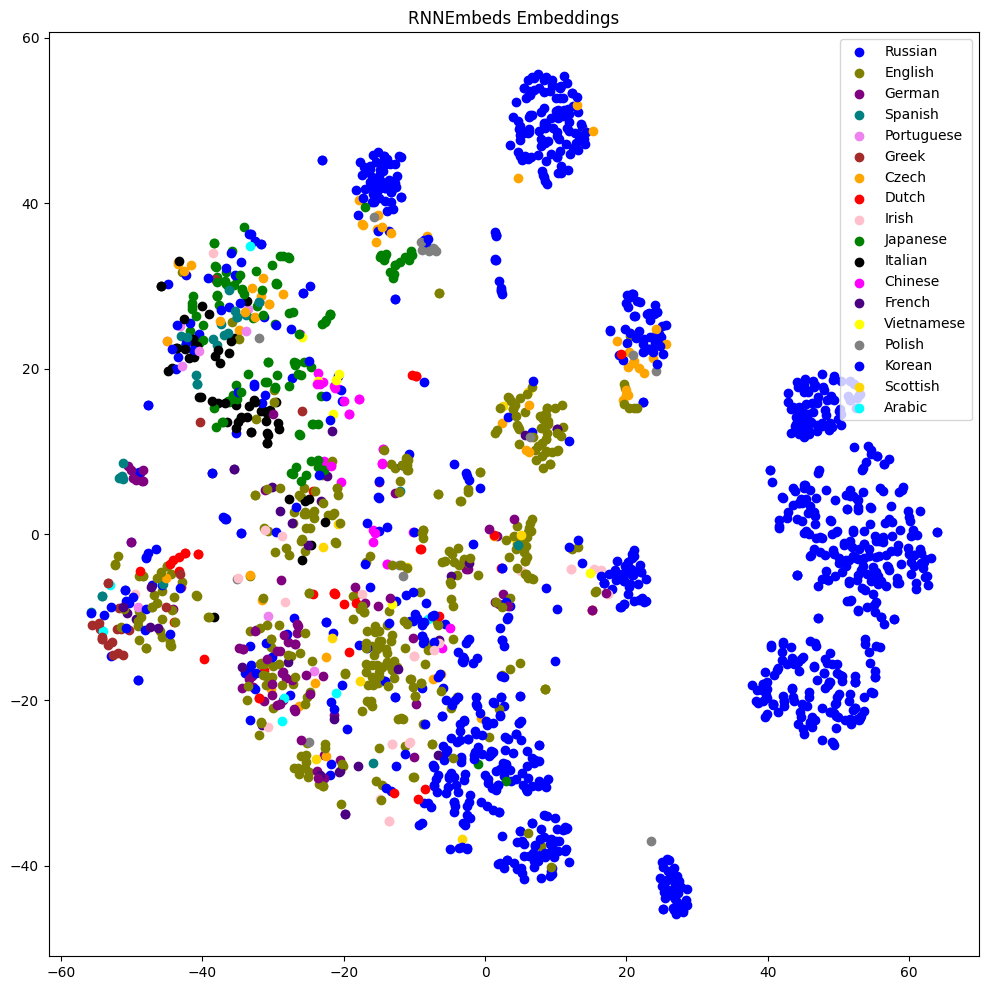

In [87]:
hidden_rnn_emb, tsne_rnn_emb = print_and_get_embeddings(rnn_embeds, indices, 'RNNEmbeds Embeddings')
sim_rnn_emb = get_embds_sim(hidden_rnn_emb)

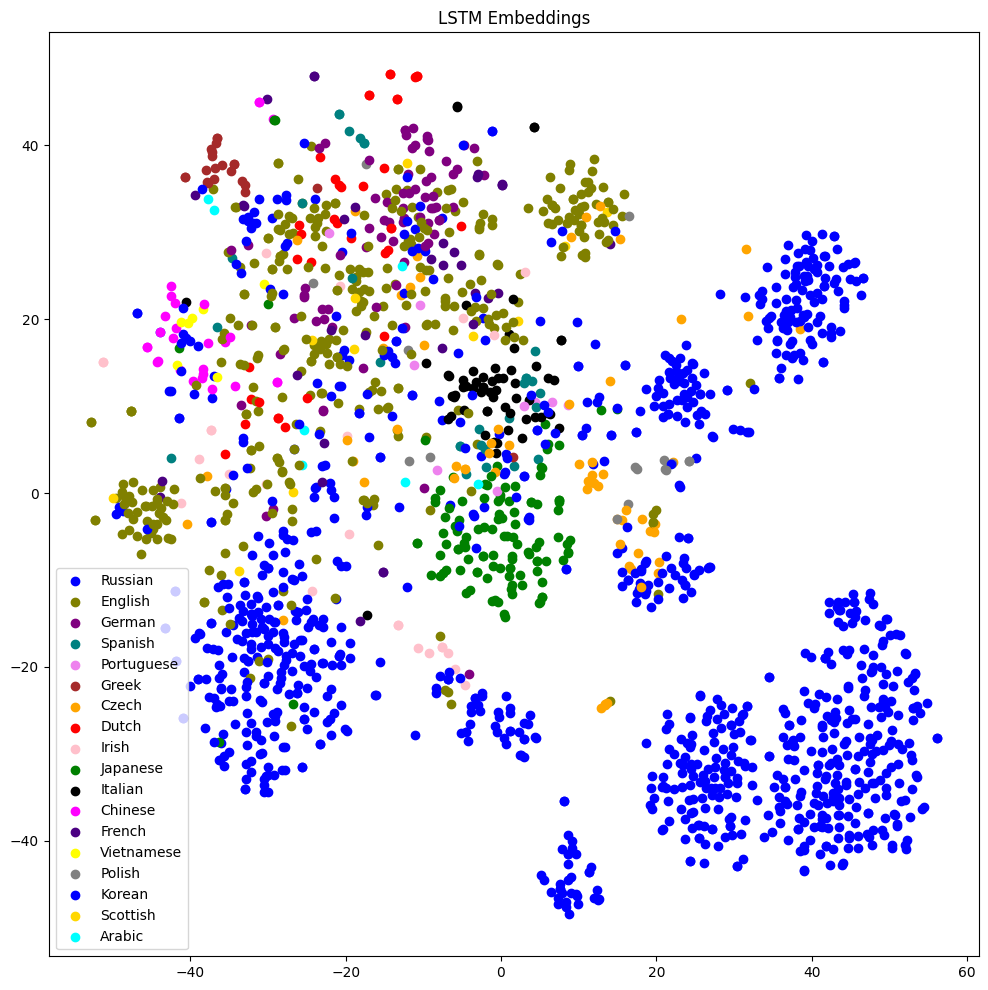

In [88]:
hidden_lstm, tsne_lstm = print_and_get_embeddings(lstm, indices, 'LSTM Embeddings')
sim_lstm = get_embds_sim(hidden_rnn_emb)

In [80]:
def get_names_similarity(embs_sim, top_k):

  dict_to_return = {}
  keys = list(name_to_lang.keys())

  for lang, names_list in category_words.items():
    rand_name = random.sample(names_list, 1)[0]

    idx_in_mat_sim = names.index(rand_name)

    most_sim_names_idx = np.flip(np.argsort(embs_sim[idx_in_mat_sim]))[:top_k]
    most_sim_names_str = [keys[idx] for idx in most_sim_names_idx]
    most_sim_names_lan = [name_to_lang[keys[idx]] for idx in most_sim_names_idx]
    most_similar_words_sim = [embs_sim[idx_in_mat_sim, idx] for idx in most_sim_names_idx]

    dict_to_return[idx_in_mat_sim] = most_sim_names_idx

    print(f'Most similar name for "{rand_name} - ({lang})" are:\t{most_sim_names_str}')
    print(f'With corresponding languages:\t{most_sim_names_lan}')
    print(f'With corresponding indices:\t{most_sim_names_idx}')
    print(f'With corresponding Embedding Cosine Similarity of:\t{most_similar_words_sim}\n')

  return dict_to_return

In [81]:
dict_sim_rnn = get_names_similarity(sim_rnn, 30)

Most similar name for "Pokhodun - (Russian)" are:	['Pokhodin', 'Pekhotin', 'Makhotin', 'Bakhorin', 'Shelyakin', 'Govyadin', 'Lokhanin', 'Ukhabin', 'Makhorin', 'Tikhonin', 'Vedyakin', 'Amelyakin', 'Markhasin', 'Tsalykhin', 'Yukhtman', 'Ilyakhin', 'Haritoshkin', 'Hudyshkin', 'Yudakhin', 'Kauphsman', 'Bokhoven', 'Shakhorin', 'Yakhnyuk', 'Yukhimuk', 'Potsyapun', 'Nakhutin', 'Judakhin', 'Zhizhikin', 'Makhonin', 'Bakhtin']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Czech', 'Dutch', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[ 6506  6350  5294  1354  7251  3223  5103  7928  5292  7451  8247   525
  5353  7597  8837  3942  3645  3920  8781 12099  9370  7155  8635  8828
  6609  5980  4520  9190  5290  1367]
With corre

In [89]:
dict_sim_rnn_emb = get_names_similarity(sim_rnn_emb, 30)

Most similar name for "Jakmon - (Russian)" are:	['Kirkman', 'Hickman', 'Bekman', 'Houston', 'Sakson', 'Kitson', 'Jokhin', 'Lepikhin', 'Djakson', 'Jakhot', 'Vaksman', 'Jakhin', 'Katzman', 'Sutton', 'Zhakmon', 'Velikson', 'Dikson', 'Hopkinson', 'Jekulin', 'Jeltukhin', 'Belokhin', 'Lupekhin', 'Jackman', 'Plikhin', 'Baklan', 'Skelton', 'Jesson', 'Lawton', 'Jewson', 'Tupikhin']
With corresponding languages:	['English', 'English', 'Russian', 'English', 'Russian', 'English', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'English', 'Russian', 'Russian', 'Russian', 'English', 'Russian', 'Russian', 'Russian', 'Russian', 'English', 'Russian', 'Russian', 'English', 'English', 'English', 'English', 'Russian']
With corresponding indices:	[15535 15150  1672 15213  7006 15544  4499  4929  2316  4104  8058  4098
  4836 16711  8949  8274  2293 15203  4297  4321  1729  5158 15295  6437
  1398 16616 15346 15625 15354  7768]
With corresponding Embedding Cosine Similarity of:	

In [90]:
dict_sim_lstm = get_names_similarity(sim_lstm, 30)

Most similar name for "Pajitnov - (Russian)" are:	['Muladjanov', 'Saksonov', 'Ujinov', 'Atiskov', 'Piskunov', 'Poroskov', 'Hanjonkov', 'Vertkov', 'Veselkov', 'Abdulladjanov', 'Serjantov', 'Veselov', 'Andrusov', 'Viskov', 'Erjenkov', 'Avgustov', 'Augustov', 'Troekurov', 'Pechkurov', 'Modestov', 'Muksunov', 'Vaskov', 'Jijnov', 'Uzunov', 'Avetisov', 'Beloshapkov', 'Atajakhov', 'Zolotkov', 'Anoskov', 'Heraskov']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[5884 7007 7924  687 6414 6571 3589 8312 8323   78 7063 8324  563 8441
 2745  787  706 7551 6342 5678 5881 8193 4409 7984  783 1738  669 9336
  598 3728]
With corresponding Embedding Cosine Similarit

In [94]:
import seaborn as sns

def plot_point_features(xy_tsne, dictionary, title):
  x = xy_tsne[:,0]
  y = xy_tsne[:,1]


  plt.figure(figsize=(20, 20))
  plot = sns.scatterplot(x=x, y=y)

  list_colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'blue', 'gray', 'orange', 'purple', 'brown', 'pink', 'teal', 'olive', 'indigo', 'violet', 'gold']

  j = 0

  for target_index, list_idx_words in dictionary.items():

      plot.text(x[target_index], y[target_index], names[target_index], horizontalalignment='center', size='small', color='black', weight='semibold')
      plt.scatter(x[target_index], y[target_index], marker='o', color=list_colors[j])

      top_similar_x = [x[i] for i in list_idx_words]
      top_similar_y = [y[i] for i in list_idx_words]

      plt.scatter(top_similar_x, top_similar_y, marker='o', color=list_colors[j], label=f'Similar to {names[target_index]} ({languages_names[target_index]})')
      j += 1

  plt.title(title)
  plt.legend()
  plt.show()

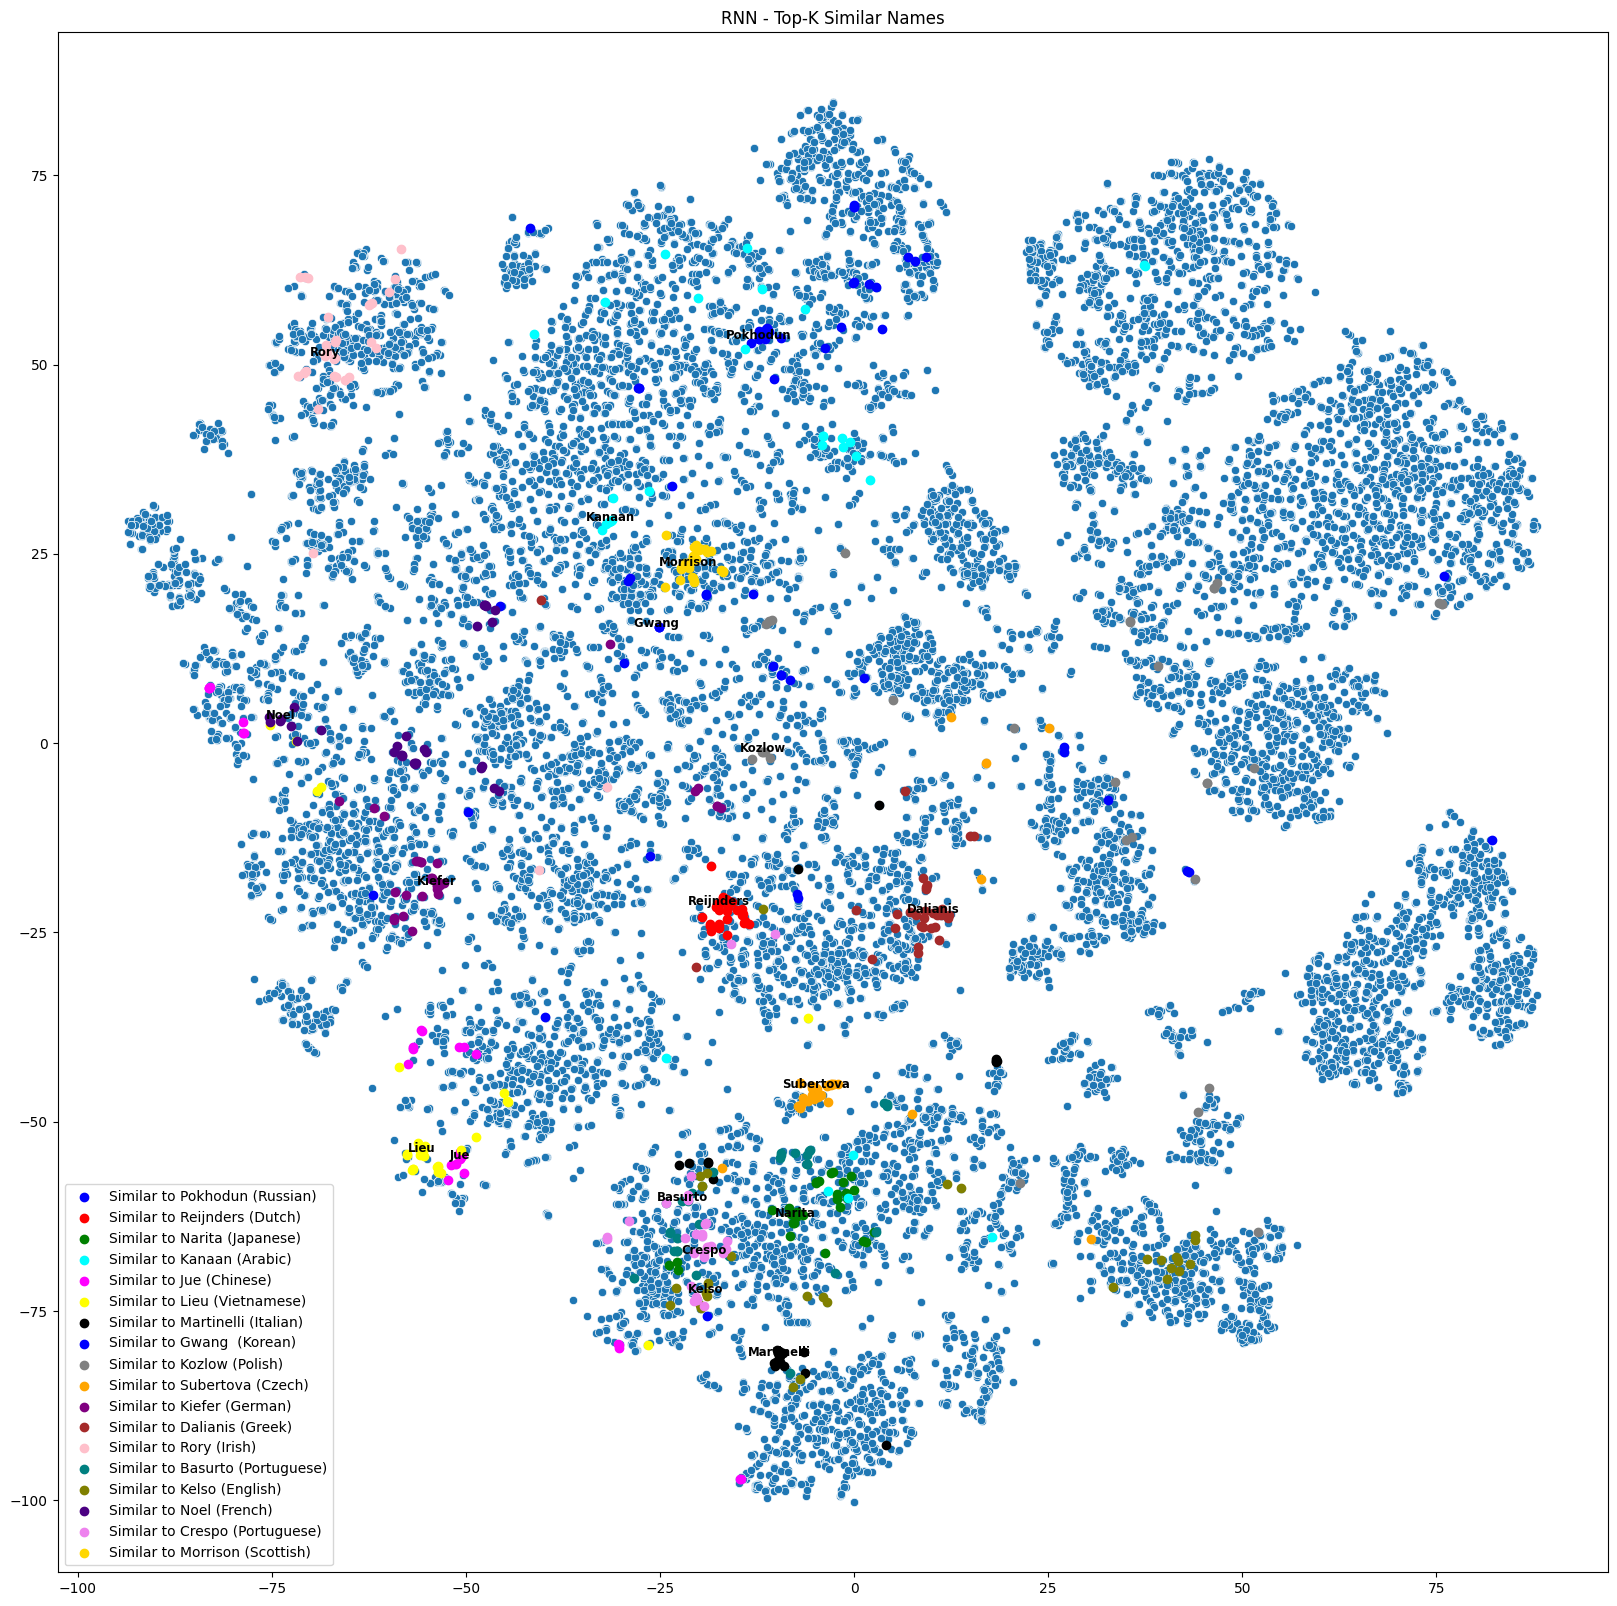

In [95]:
plot_point_features(tsne_rnn, dict_sim_rnn, 'RNN - Top-K Similar Names')

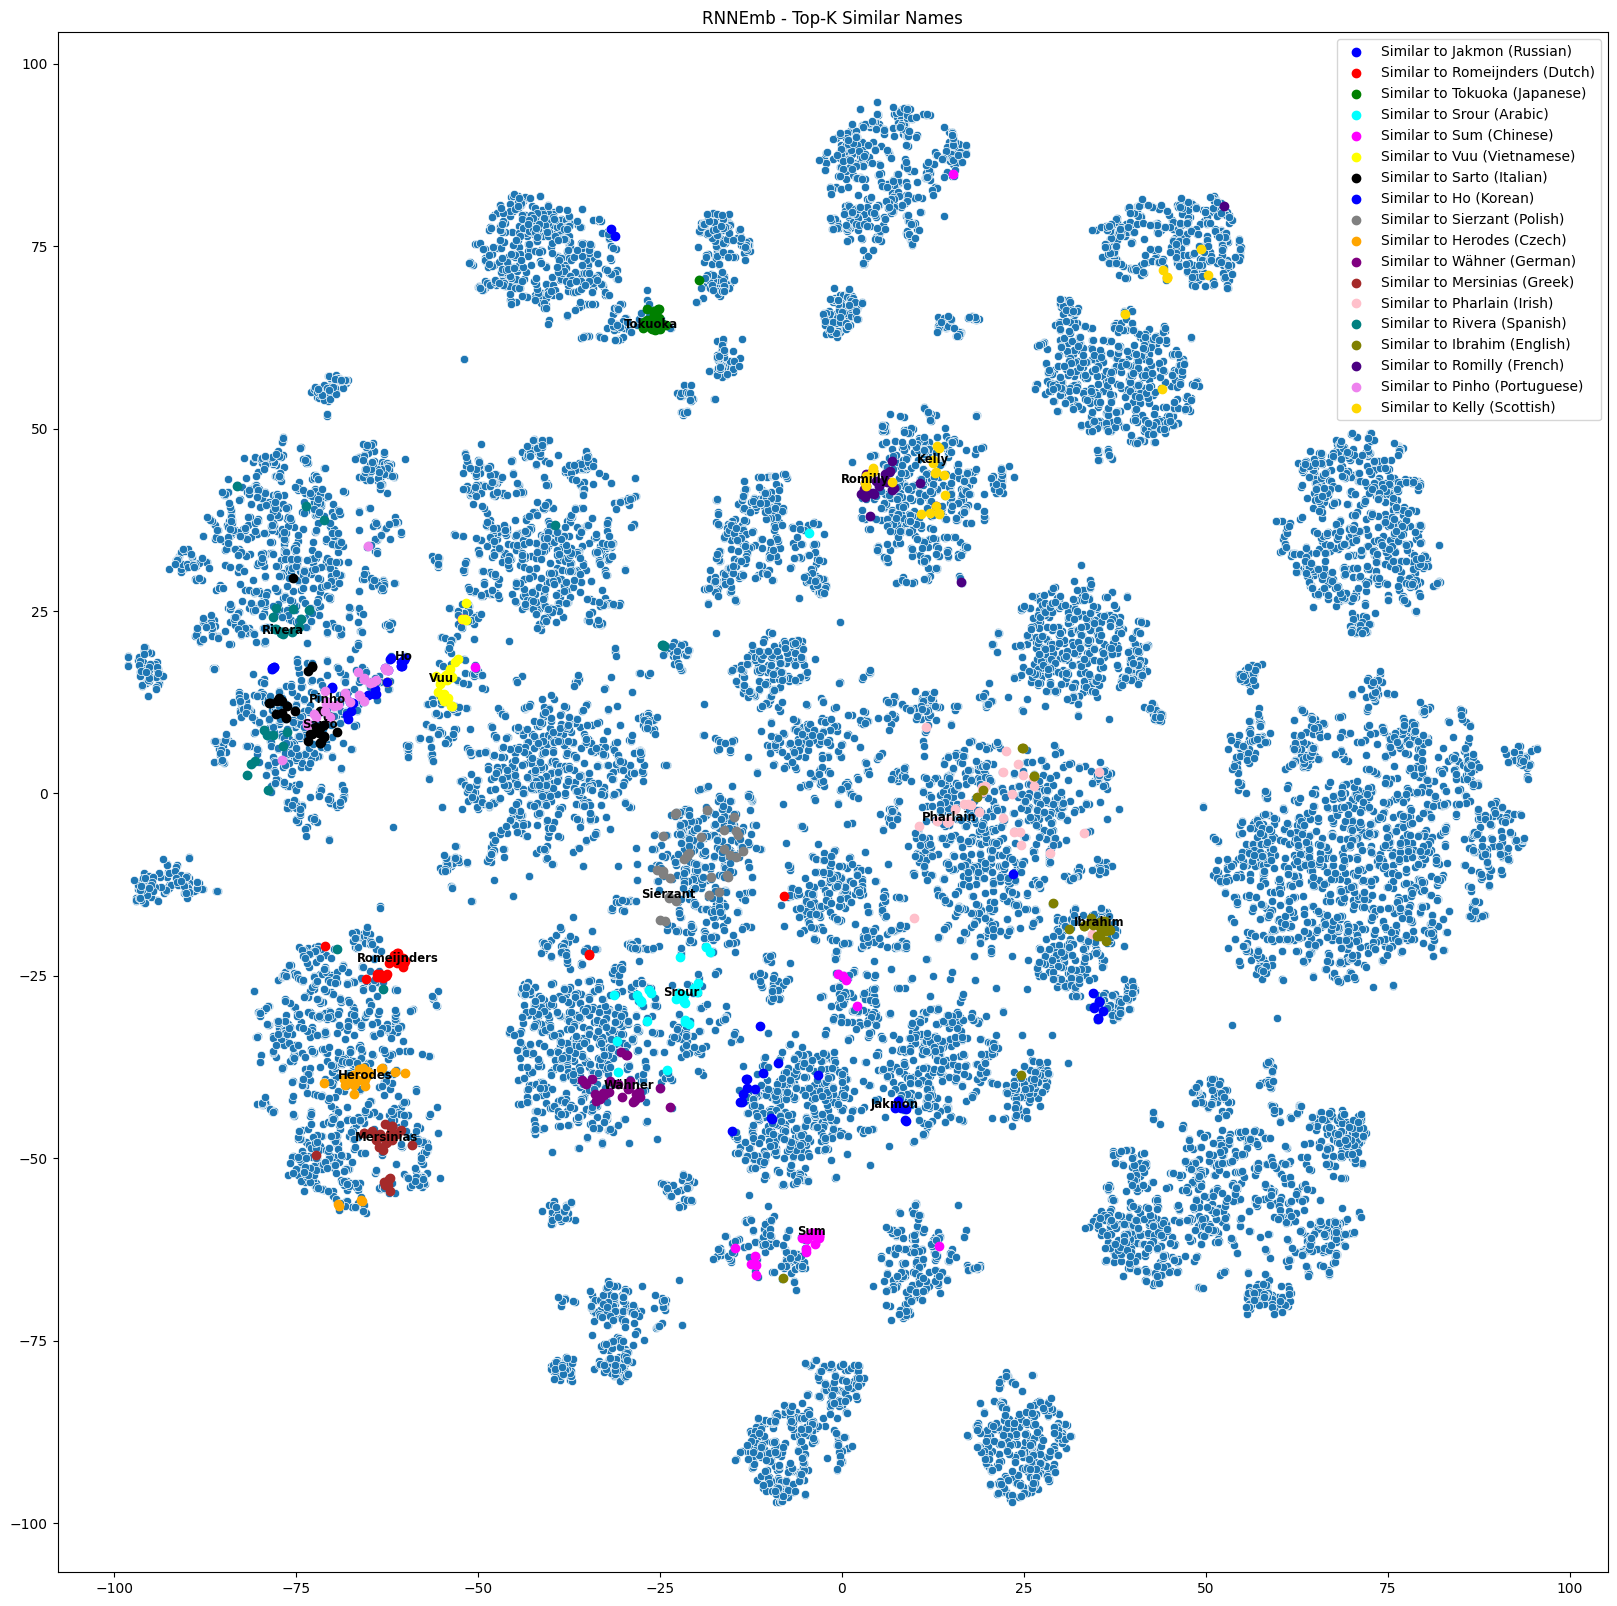

In [96]:
plot_point_features(tsne_rnn_emb, dict_sim_rnn_emb, 'RNNEmb - Top-K Similar Names')

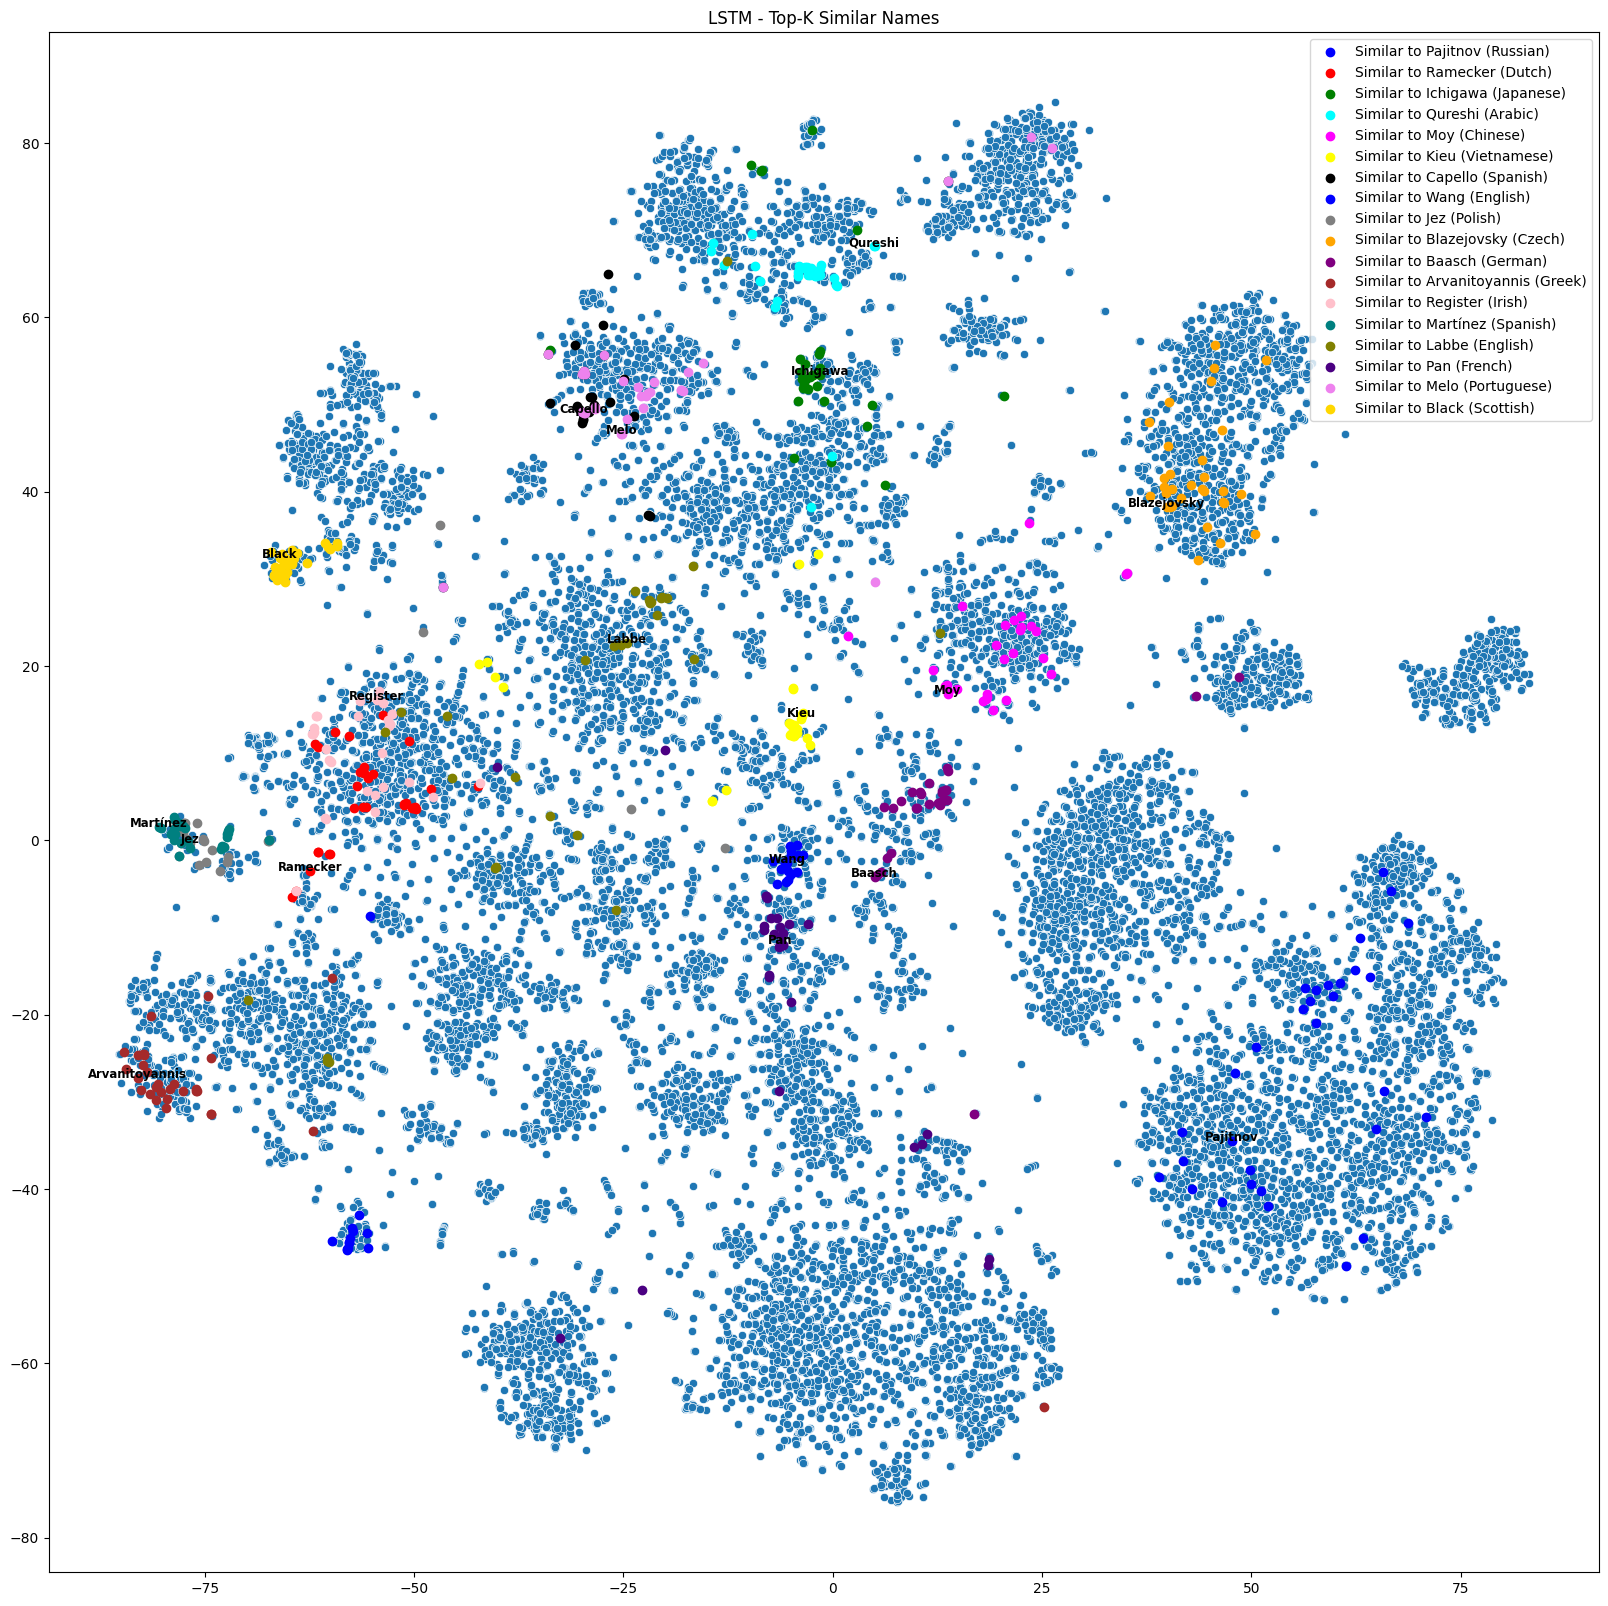

In [97]:
plot_point_features(tsne_lstm, dict_sim_lstm, 'LSTM - Top-K Similar Names')